In [1]:
from plugins.calibration.sn_calibration_baseline.camera import Camera
import cv2
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json

# plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
camParamsPath = "Labels-GameState - Copy.json"
imgPath = 'Images/img1/'
maskPath = 'out2/tta/'
imgNum = 500

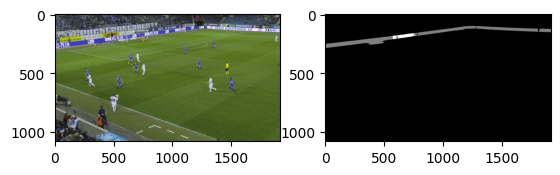

In [3]:
with open(camParamsPath, "r") as f:
	camParams = json.load(f)["annotations"]
camParams = [x["parameters"] for x in camParams if x["supercategory"] == "camera"]
cam = Camera()
cam.from_json_parameters(camParams[imgNum - 1])  # camParams is 0-indexed whereas img_num is 1-indexed
img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# plot img and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

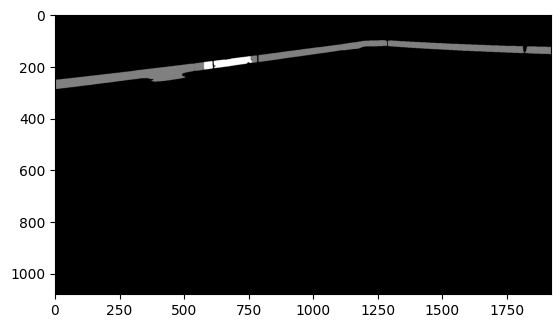

In [4]:
plt.imshow(mask, cmap='gray')
plt.savefig('mask.png', dpi=600)

In [5]:
billboardDepth = 4
points = np.float64([[-105/2 - billboardDepth, i, 0] for i in range(-34, 34+1, 2)])
points

array([[-56.5, -34. ,   0. ],
       [-56.5, -32. ,   0. ],
       [-56.5, -30. ,   0. ],
       [-56.5, -28. ,   0. ],
       [-56.5, -26. ,   0. ],
       [-56.5, -24. ,   0. ],
       [-56.5, -22. ,   0. ],
       [-56.5, -20. ,   0. ],
       [-56.5, -18. ,   0. ],
       [-56.5, -16. ,   0. ],
       [-56.5, -14. ,   0. ],
       [-56.5, -12. ,   0. ],
       [-56.5, -10. ,   0. ],
       [-56.5,  -8. ,   0. ],
       [-56.5,  -6. ,   0. ],
       [-56.5,  -4. ,   0. ],
       [-56.5,  -2. ,   0. ],
       [-56.5,   0. ,   0. ],
       [-56.5,   2. ,   0. ],
       [-56.5,   4. ,   0. ],
       [-56.5,   6. ,   0. ],
       [-56.5,   8. ,   0. ],
       [-56.5,  10. ,   0. ],
       [-56.5,  12. ,   0. ],
       [-56.5,  14. ,   0. ],
       [-56.5,  16. ,   0. ],
       [-56.5,  18. ,   0. ],
       [-56.5,  20. ,   0. ],
       [-56.5,  22. ,   0. ],
       [-56.5,  24. ,   0. ],
       [-56.5,  26. ,   0. ],
       [-56.5,  28. ,   0. ],
       [-56.5,  30. ,   0. ],
       [-5

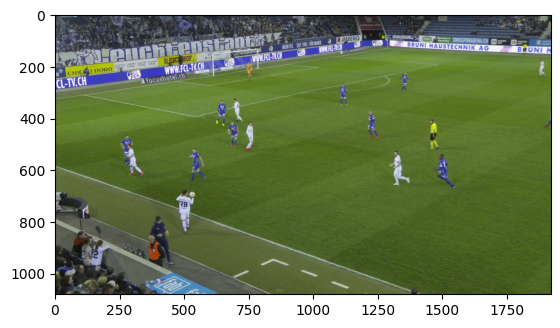

In [6]:
img2 = deepcopy(img)
for pt in points:
	pt = cam.project_point(pt, distort=True)[:2]
	cv2.circle(img2, tuple(pt.astype(np.int32)), 2, (0, 255, 0), -1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

[[-528.45526   377.87064 ]
 [-528.45526   289.6218  ]
 [1208.6796     80.964905]
 [1208.6796    127.79301 ]]


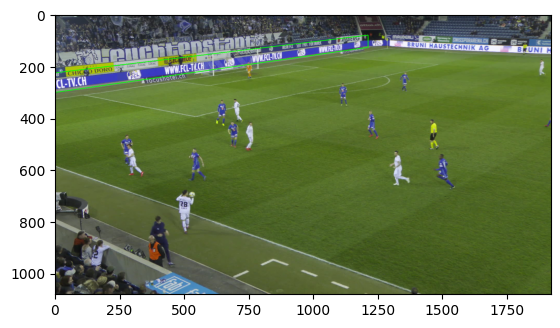

In [7]:
billboardHeight = 2
worldSrcPoints = np.float64([[-105/2 - billboardDepth, 34, 0], [-105/2 - billboardDepth, 34, -billboardHeight], [-105/2 - billboardDepth, -34, -billboardHeight], [-105/2 - billboardDepth, -34, 0]])
# worldSrcPoints = np.float64([[-105/2 - depth, 20, 0], [-105/2 - depth, 20, -billboardHeight], [-105/2 - depth, -34, -billboardHeight], [-105/2 - depth, -34, 0]])
srcPoints = np.float32([cam.project_point(pt, distort=False)[:2] for pt in worldSrcPoints])
srcPoints[1][0] = srcPoints[0][0]
srcPoints[2][0] = srcPoints[3][0]
print(srcPoints)
tmp = deepcopy(img)
cv2.polylines(tmp, [np.rint(srcPoints).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

# !!! It is not done yet but it seems that a warpedImgHeight of odd size is better for cv.remap() function (to test with a grid) !!! Also 'warpedImgHeight' should be at least as great as the billboard new content height, or else there will be some loss when a down scaling is done later. But right now it is not very visible and it is expensive to not down scale

In [8]:
# To prepent loss of resolution when warping back the new content of the billboard, the warped image shoudl have a height greater than the height of the billow green window
warpedImgHeight = np.ceil(max(abs(srcPoints[0][1] - srcPoints[1][1]), abs(srcPoints[2][1] - srcPoints[3][1]))).astype(np.int32)
if warpedImgHeight % 2 == 0:
	warpedImgHeight += 1
print(warpedImgHeight)
warpedImgSize = (int(round(warpedImgHeight * 68 / billboardHeight)), warpedImgHeight)
warpedImgSize

89


(3026, 89)

In [9]:
dstPoints = np.float32([[0, warpedImgSize[1]], [0, 0], [warpedImgSize[0], 0], [warpedImgSize[0], warpedImgSize[1]]])
dstPoints

array([[   0.,   89.],
       [   0.,    0.],
       [3026.,    0.],
       [3026.,   89.]], dtype=float32)

In [10]:
M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
M

array([[ 1.07830931e+00,  8.95689472e-16,  5.69838231e+02],
       [ 1.41315760e-01,  1.17649854e+00, -2.66060564e+02],
       [-3.15199618e-04,  2.71671769e-19,  1.00000000e+00]])

In [11]:
def warpDstPointToSrcPoint(M, dstPoint):
    # inverse M
    # M = np.linalg.inv(M)
    return [(M[0][0] * dstPoint[0] + M[0][1] * dstPoint[1] + M[0][2]) / (M[2][0] * dstPoint[0] + M[2][1] * dstPoint[1] + M[2][2]), (M[1][0] * dstPoint[0] + M[1][1] * dstPoint[1] + M[1][2]) / (M[2][0] * dstPoint[0] + M[2][1] * dstPoint[1] + M[2][2] )]
warpDstPointToSrcPoint(M, [0, 0])

[569.8382305007024, -266.06056413594837]

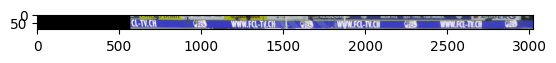

In [12]:
warpedImg = cv2.warpPerspective(img, M, warpedImgSize)
# the plot x axis should range from 0 to warpedImgSize[0] with a step of 100
plt.imshow(cv2.cvtColor(warpedImg, cv2.COLOR_BGR2RGB))

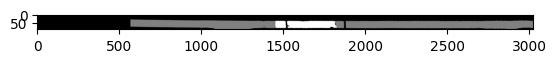

In [13]:
warpedMask = cv2.warpPerspective(mask, M, warpedImgSize)
plt.imshow(warpedMask, cmap='gray')
plt.savefig('warpedMask.png', dpi=600)

In [14]:
binWarpedMask = warpedMask > 0
y, x = np.where(binWarpedMask)
print(min(y), max(y), min(x), max(x))

32 88 570 3025


In [15]:
poly = PolynomialFeatures(degree=2, include_bias=True)
X = poly.fit_transform(x.reshape(-1, 1))
reg = LinearRegression().fit(X, y)
reg.predict(X).shape

(106659,)

In [16]:
Y = reg.predict(X)
width = np.mean(abs(y - Y)) * 2
width

22.080464131758347

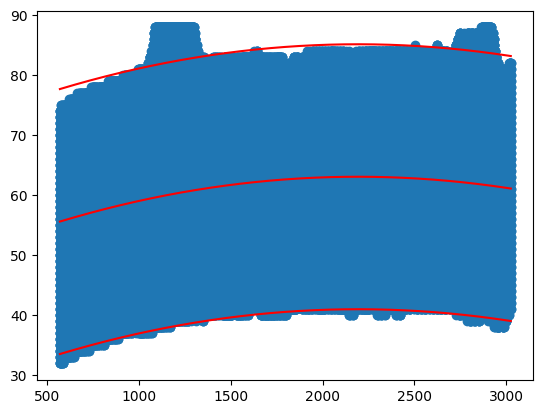

In [17]:
# plot x, y and the regression line
plt.scatter(x, y)
x_sorted = np.sort(x)
X_sorted = poly.fit_transform(x_sorted.reshape(-1, 1))
plt.plot(x_sorted, reg.predict(X_sorted), color='red')
plt.plot(x_sorted, reg.predict(X_sorted) + width, color='red')
plt.plot(x_sorted, reg.predict(X_sorted) - width, color='red')
plt.show()

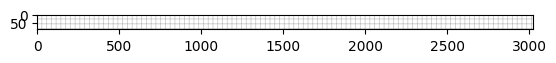

In [18]:
gridWidth = warpedImgSize[0]
gridHeight = warpedImgSize[1]
squareSize = gridHeight // 3
grid = np.zeros((gridHeight, gridWidth, 3), dtype=np.uint8)
grid.fill(255)
for i in range(0, gridWidth, squareSize):
	cv2.line(grid, (i, 0), (i, gridHeight), (0, 0, 0), 1)
for i in range(0, gridHeight, squareSize):
	cv2.line(grid, (0, i), (gridWidth, i), (0, 0, 0), 1)
plt.imshow(grid)

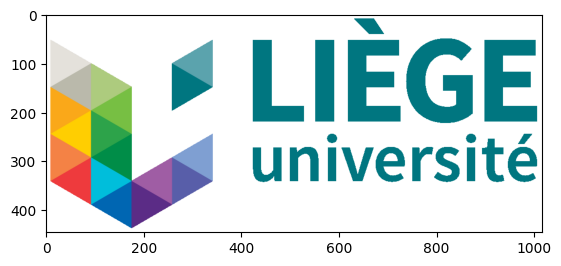

In [19]:
logo = cv2.imread('University_of_Liège_logo.png')
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))

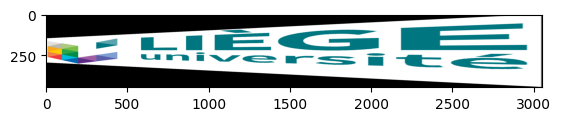

In [20]:
tmp = np.zeros((logo.shape[0], logo.shape[1]*3, 3), dtype=np.uint8)
srcPoints = np.float32([[0, 0], [0, logo.shape[0]], [logo.shape[1], logo.shape[0]], [logo.shape[1], 0]])
dstPoints = np.float32([[0, tmp.shape[0]//3], [0, tmp.shape[0]//3*2], [tmp.shape[1], tmp.shape[0]], [tmp.shape[1], 0]])
Mtmp = cv2.getPerspectiveTransform(srcPoints, dstPoints)
# %timeit cv2.warpPerspective(logo, Mtmp, (tmp.shape[1], tmp.shape[0]))
tmp = cv2.warpPerspective(logo, Mtmp, (tmp.shape[1], tmp.shape[0]))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

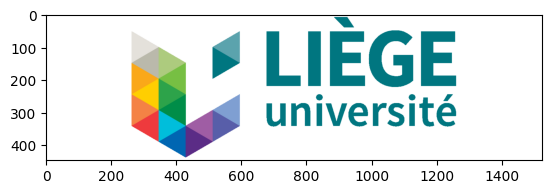

In [21]:
# pad in white of 50 pixels on each side
logo = cv2.imread('University_of_Liège_logo.png')
logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(255, 255, 255))
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))

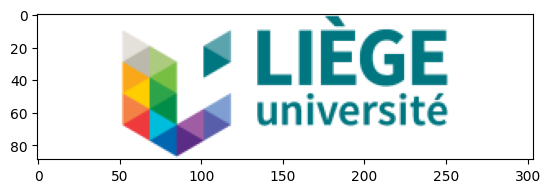

In [22]:
# Resize the logo to a height of gridHeight and conserve the aspect ratio
logoHeight = gridHeight
logoWidth = int(round(logo.shape[1] * logoHeight / logo.shape[0]))
logoWidth

logo2 = cv2.resize(logo, (logoWidth, logoHeight), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(logo2, cv2.COLOR_BGR2RGB))

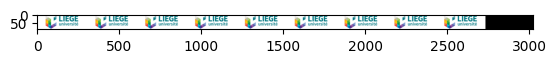

In [23]:
# Concatenate the logos to fill the grid
logos = np.concatenate([logo2 for _ in range(gridWidth//logoWidth)], axis=1)
# The concatenation has a width of gridWidth//logoWidth, fill the remaining space on the right in black such that the final width is gridWidth
logos = np.concatenate([logos, np.zeros((logoHeight, gridWidth - logos.shape[1], 3), dtype=np.uint8)], axis=1)
plt.imshow(cv2.cvtColor(logos, cv2.COLOR_BGR2RGB))

In [24]:
grid = logos

In [25]:
25 - 0.25 * gridHeight

2.75

In [26]:
# mapX = np.zeros(warpedMask.shape, dtype=np.float32)
# mapY = np.zeros(warpedMask.shape, dtype=np.float32)
# for i in tqdm(range(gridHeight)):
# 	for j in range(gridWidth):
# 		mapX[i, j] = j
# 		if i >= 0.25 * gridHeight and i <= 0.75 * gridHeight:
# 			mapY[i, j] = 2 * (i - 0.25 * gridHeight)
# remappedGrid = cv2.remap(grid, mapX, mapY, cv2.INTER_LINEAR)
# remappedGrid = cv2.resize(remappedGrid, (gridWidth, 4000))
# plt.imshow(cv2.cvtColor(remappedGrid, cv2.COLOR_BGR2RGB))

In [27]:
x = np.arange(0, gridWidth)
x = poly.fit_transform(x.reshape(-1, 1))
print(width)
y = [(x_ - width, x_ + width) for x_ in reg.predict(x)]
y = np.rint(np.array(y)).astype(np.int32)
print(y)

22.080464131758347
[[27 72]
 [27 72]
 [27 72]
 ...
 [39 83]
 [39 83]
 [39 83]]


100%|██████████| 3026/3026 [00:00<00:00, 9294.66it/s]


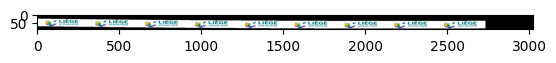

In [28]:
mapX = - np.ones(warpedMask.shape, dtype=np.float32)
mapY = - np.ones(warpedMask.shape, dtype=np.float32)
for i in range(gridHeight):
	for j in range(gridWidth):
		mapX[i, j] = j
for j , (yBegin, yEnd) in enumerate(tqdm(y)):
	length = yEnd - yBegin
	for i in range(yBegin, yEnd + 1):
		mapY[i, j] = (i - yBegin) / length * (gridHeight - 1)
remappedGrid = cv2.remap(grid, mapX, mapY, cv2.INTER_LINEAR)
# remappedGrid = cv2.resize(remappedGrid, (gridWidth, 4000))
plt.imshow(cv2.cvtColor(remappedGrid, cv2.COLOR_BGR2RGB))
# save the remapped grid with a dpi of 600
plt.savefig('remapped_grid.png', dpi=300)

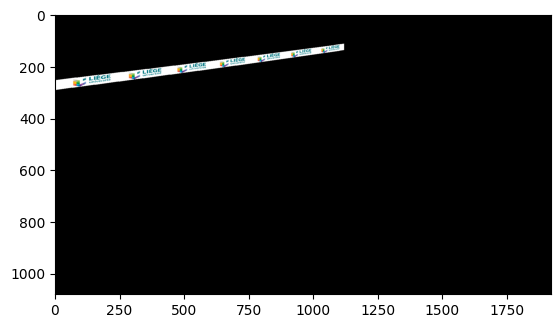

In [29]:
warpedToWorldGrid = cv2.warpPerspective(remappedGrid, M, img.shape[1::-1], flags=cv2.WARP_INVERSE_MAP)
plt.imshow(cv2.cvtColor(warpedToWorldGrid, cv2.COLOR_BGR2RGB))

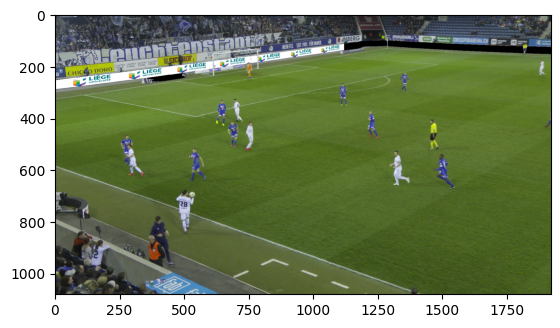

In [30]:
binMask = mask > 0
finalImg = deepcopy(img)
finalImg[binMask] = warpedToWorldGrid[binMask]
plt.imshow(cv2.cvtColor(finalImg, cv2.COLOR_BGR2RGB))
# plt.savefig('final_img2.png', dpi=600)